<a href="https://colab.research.google.com/github/Skevrek/MBA_Thesis/blob/main/MLP_RegressionSemis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import pylab as pl
import numpy as np
import seaborn as sns
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from google.colab import data_table
data_table.enable_dataframe_formatter()

In [2]:
df = pd.read_excel("/content/drive/MyDrive/MBA/DataTables_Semis-Forecasting/DataTable_Semis-Forecasting-1M.xlsx")

In [3]:
df.tail(5)

,Date,PPI,PPI_Lagged,GPR,Export_Semis,Import_Semis,Employees_Semis,Export_NoSemis,Import_NoSemis,RIW_Semis,Export_CapitalGoods,IP_NoEnergy
344,2022-09-01,4.039924,4.036574,4.905679,4.125520,4.115780,5.971007,3.837299,4.799914,0.237914,4.987708,4.608036
345,2022-10-01,4.048527,4.039924,4.897674,4.127134,4.115780,5.968196,3.845883,4.799091,0.216884,4.988390,4.607506
346,2022-11-01,4.052446,4.048527,4.982745,4.117410,4.120662,5.972282,3.828641,4.799914,0.186065,4.989752,4.610189
347,2022-12-01,4.053141,4.052446,4.776836,4.109233,4.120662,5.974827,3.808882,4.800737,0.161779,4.991113,4.604340
348,2023-01-01,4.045749,4.053141,4.734916,4.100989,4.120662,5.976351,3.806662,4.805659,0.139936,4.993828,4.586698


In [4]:
df.columns

Index(['Date', 'PPI', 'PPI_Lagged', 'GPR', 'Export_Semis', 'Import_Semis',
       'Employees_Semis', 'Export_NoSemis', 'Import_NoSemis', 'RIW_Semis',
       'Export_CapitalGoods', 'IP_NoEnergy'],
      dtype='object')

In [5]:
cdf_1M = df[['PPI','PPI_Lagged']]

In [6]:
# Split data into train and test sets based on time-series index
train_size = int(len(cdf_1M) * 0.7)
train, test = cdf_1M.iloc[:train_size], cdf_1M.iloc[train_size:]

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Prepare the data for MLP regression
X_train = train_scaled[:, 1:]
y_train = train_scaled[0:, 0]

# # Include the first and last row in the training data
# X_train = np.concatenate([train_scaled[:1, :], X_train, train_scaled[-1:, 1:]], axis=0)
# y_train = np.concatenate([train_scaled[:1, 0], y_train, train_scaled[-1:, 0]], axis=0)

# Fit the scaler on the training set only
scaler.fit(train)

# Use the same scaler to transform the testing set
test_with_feature_names = pd.DataFrame(test_scaled, columns=test.columns)
X_test = scaler.transform(test_with_feature_names)
y_test = test_scaled[0:, 0]

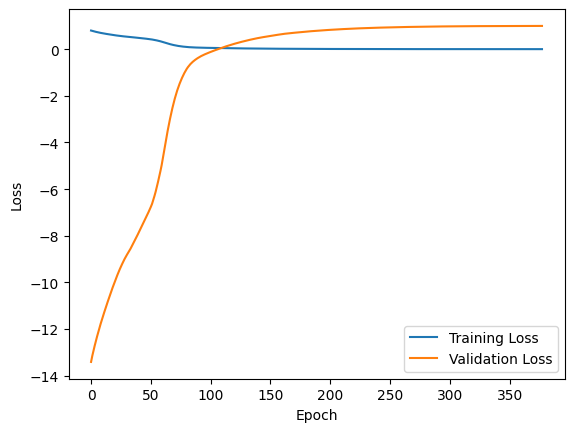

In [7]:
# define the MLP model

np.random.seed(42)

model = MLPRegressor(hidden_layer_sizes=(6,4), activation='relu', solver='adam', alpha=0.00001, max_iter=1000, batch_size='auto', verbose=False, early_stopping=True)

# train the model
history = model.fit(X_train, y_train)

# Plot the training and validation loss curves
plt.plot(history.loss_curve_, label='Training Loss')
plt.plot(model.validation_scores_, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# # plot the training and validation loss curves
# plt.plot(model.loss_curve_, label='Training Loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()


In [8]:
import itertools
# make predictions on the test set
y_pred = model.predict(test_scaled[:, 1:])
y_pred = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1,1), test_scaled[:, 1:]), axis=1))[:, 0]
y_true = test['PPI'].values



# evaluate the model
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# print the metrics
print('number of iterations the solver: ', model.n_iter_)
print('Num of o/p: ', model.n_outputs_)
print('MAE:', mae)
print('MSE:', mse)
print('R2 Score:', r2)

number of iterations the solver:  378
Num of o/p:  1
MAE: 0.008553814868706695
MSE: 8.87186504290168e-05
R2 Score: 0.8568473789236716


In [9]:
# print('Actual vs Predicted:')
# print(np.column_stack((y_true, y_pred)))

In [10]:
scaler_y = MinMaxScaler()
train_scaled_y = scaler_y.fit_transform(train.iloc[:, :1])
test_scaled_y = scaler_y.transform(test.iloc[:, :1])
train_y_pred = model.predict(X_train)
train_mape = np.mean(np.abs((scaler_y.inverse_transform(train_y_pred.reshape(-1, 1)) - scaler_y.inverse_transform(y_train.reshape(-1, 1))) / scaler_y.inverse_transform(y_train.reshape(-1, 1))) * 100)
print("Train MAPE: {:.8f}%".format(train_mape))
# train_mape = np.mean(np.abs((X_train - y_train) / np.maximum(X_train, 1e-8))) * 100
# print("Train MAPE: {:.8f}%".format(train_mape))


test_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.16858272%
Test MAPE: 0.21223070%


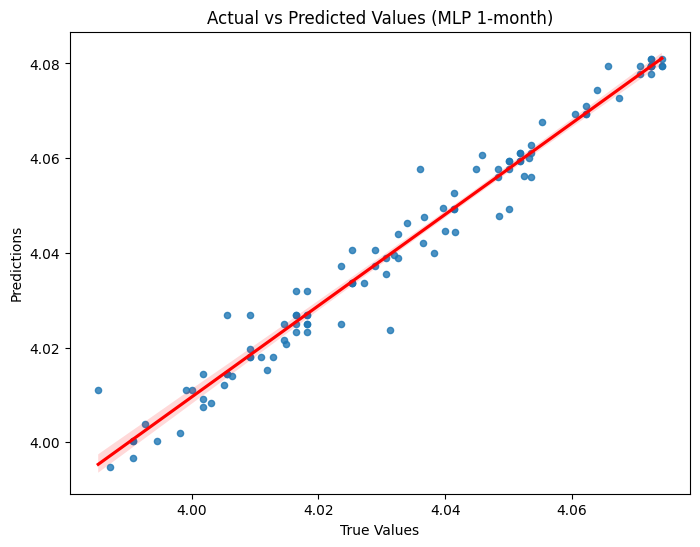

In [11]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot actual vs predicted values
sns.regplot(x=y_true, y=y_pred, scatter_kws={"s": 20}, line_kws={"color": "red"})
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Actual vs Predicted Values (MLP 1-month)")
plt.show()

In [12]:
# train_actual = y_train.reset_index(drop=True)
# train_pred = pd.DataFrame(model.predict(X_train), columns=['PPI_pred'])

# # Create dataframes for actual and predicted values of test set
# test_actual = y_test.reset_index(drop=True)
# test_pred = pd.DataFrame(y_true, columns=['PPI_pred'])

# # Concatenate actual and predicted values for train and test sets
# train_df = pd.concat([train_actual, train_pred], axis=1)
# test_df = pd.concat([test_actual, test_pred], axis=1)

# # Calculate MAPE for train and test sets separately
# train_df['MAPE'] = np.abs(train_df['PPI'] - train_df['PPI_pred']) / train_df['PPI']
# test_df['MAPE'] = np.abs(test_df['PPI'] - test_df['PPI_pred']) / test_df['PPI']

# # Print train and test MAPE results
# print("Train MAPE: {:.8%}".format(train_df['MAPE'].mean()))
# print("Test MAPE: {:.8%}".format(test_df['MAPE'].mean()))

In [13]:
# n_months = 1

# # Create an array of lagged PPI values for the next n_months
# X = cdf_1M['PPI_Lagged'].tail(n_months).values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
# scaler.fit(X)
# # Scale the input features
# X_scaled = scaler.transform(X)

# # Create an empty array to hold the forecasted PPI values
# forecast = []
# last_observation_scaled = X_scaled[0]
# for i in range(n_months):
#     # Make a prediction based on the last observation

#     y_pred = model.predict([last_observation_scaled])
#     # Inverse transform the prediction
#     y_pred_inv = scaler.inverse_transform([[y_pred, 0]])[0][0]
#     # Append the prediction to the forecast array
#     forecast.append(y_pred_inv)
#     # Update the last observation
#     last_observation_scaled = np.concatenate([y_pred, X_scaled[i][1:]])

# # Create a dataframe to hold the forecasted PPI values
# forecast_df = pd.DataFrame(data=forecast, columns=['PPI'])

# # Create an index for the forecasted PPI values
# forecast_index = pd.date_range(start=cdf_1M.index[-1], periods=1, freq='MS')
# forecast_df.set_index(forecast_index, inplace=True)

# # Plot the predicted PPI values
# plt.plot(range(len(cdf_1M)), cdf_1M['PPI'], label='Historical PPI')
# plt.plot(range(len(cdf_1M), len(cdf_1M)+n_months), forecast_df, label='Forecasted PPI')
# plt.xlabel('Time (months)')
# plt.ylabel('PPI')
# plt.legend()
# plt.show()

# # print the forecasted PPI values
# print(forecast_df.values)

**FORECAST 3 MONTHS**

In [14]:
df = pd.read_excel("/content/drive/MyDrive/MBA/DataTables_Semis-Forecasting/DataTable_Semis-Forecasting-3M.xlsx")

In [15]:
df.tail(5)

,Date,PPI,PPI_Lagged,GPR,Export_Semis,Import_Semis,Employees_Semis,Export_NoSemis,Import_NoSemis,RIW_Semis,Export_CapitalGoods,IP_NoEnergy
342,2022-09-01,4.039924,4.041576,4.904500,4.117410,4.122284,5.956614,3.860730,4.797442,0.274445,4.980176,4.606434
343,2022-10-01,4.048527,4.039607,4.779006,4.117410,4.119037,5.963579,3.856510,4.799914,0.258511,4.987025,4.608073
344,2022-11-01,4.052446,4.036574,4.905679,4.125520,4.115780,5.971007,3.837299,4.799914,0.237914,4.987708,4.608036
345,2022-12-01,4.053141,4.039924,4.897674,4.127134,4.115780,5.968196,3.845883,4.799091,0.216884,4.988390,4.607506
346,2023-01-01,4.045749,4.048527,4.982745,4.117410,4.120662,5.972282,3.828641,4.799914,0.186065,4.989752,4.610189


In [16]:
df.columns

Index(['Date', 'PPI', 'PPI_Lagged', 'GPR', 'Export_Semis', 'Import_Semis',
       'Employees_Semis', 'Export_NoSemis', 'Import_NoSemis', 'RIW_Semis',
       'Export_CapitalGoods', 'IP_NoEnergy'],
      dtype='object')

In [17]:
cdf_3M = df[['PPI','PPI_Lagged', 'Employees_Semis']]

In [18]:
# Split data into train and test sets based on time-series index
train_size = int(len(cdf_3M) * 0.8)
train, test = cdf_3M.iloc[:train_size], cdf_3M.iloc[train_size:]

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Prepare the data for MLP regression
X_train = train_scaled[:, 1:]
y_train = train_scaled[0:, 0]

# Fit the scaler on the training set only
scaler.fit(train)

# Use the same scaler to transform the testing set
test_with_feature_names = pd.DataFrame(test_scaled, columns=test.columns)
X_test = scaler.transform(test_with_feature_names[:])[:]
y_test = test_scaled[0:, 0]

In [19]:
len(y_test)

70

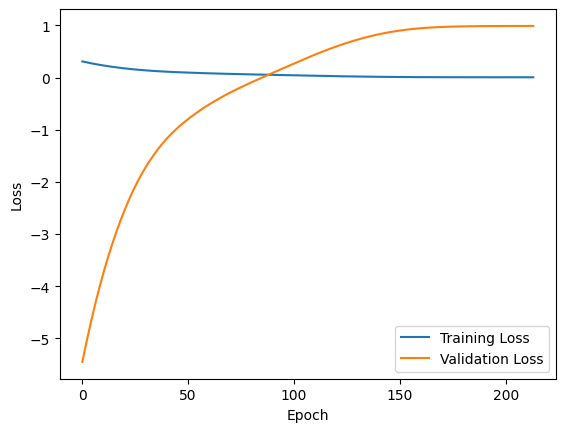

In [20]:
# define the MLP model

np.random.seed(42)

model = MLPRegressor(hidden_layer_sizes=(6,4), activation='tanh', solver='adam', alpha=0.1, max_iter=1000, batch_size='auto', verbose=False, early_stopping=True)

# train the model
history = model.fit(X_train, y_train)

# Plot the training and validation loss curves
plt.plot(history.loss_curve_, label='Training Loss')
plt.plot(model.validation_scores_, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# # plot the training and validation loss curves
# plt.plot(model.loss_curve_, label='Training Loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()


In [21]:
import itertools
# make predictions on the test set
y_pred = model.predict(test_scaled[:, 1:])
y_pred = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1,1), test_scaled[:, 1:]), axis=1))[:, 0]
y_true = test['PPI'].values

# evaluate the model
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# print the metrics
print('number of iterations the solver: ', model.n_iter_)
print('Num of o/p: ', model.n_outputs_)
print('MAE:', mae)
print('MSE:', mse)
print('R2 Score:', r2)

number of iterations the solver:  214
Num of o/p:  1
MAE: 0.0068660091927546405
MSE: 8.109440363669809e-05
R2 Score: 0.7305550149246168


In [22]:
# print('Actual vs Predicted:')
# print(np.column_stack((y_true, y_pred)))

In [23]:
len(y_true)

70

In [24]:
scaler_y = MinMaxScaler()
train_scaled_y = scaler_y.fit_transform(train.iloc[:, :1])
test_scaled_y = scaler_y.transform(test.iloc[:, :1])
train_y_pred = model.predict(X_train)
train_mape = np.mean(np.abs((scaler_y.inverse_transform(train_y_pred.reshape(-1, 1)) - scaler_y.inverse_transform(y_train.reshape(-1, 1))) / scaler_y.inverse_transform(y_train.reshape(-1, 1))) * 100)
print("Train MAPE: {:.8f}%".format(train_mape))
# train_mape = np.mean(np.abs((X_train - y_train) / np.maximum(X_train, 1e-8))) * 100
# print("Train MAPE: {:.8f}%".format(train_mape))


test_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.33479820%
Test MAPE: 0.17083554%


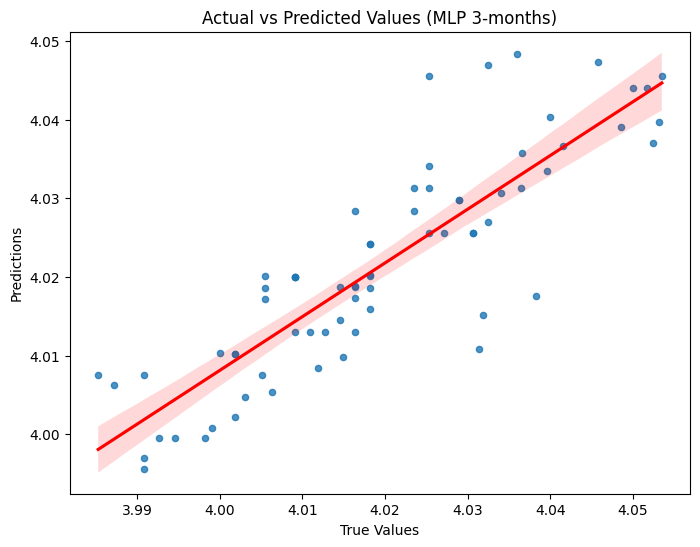

In [25]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot actual vs predicted values
sns.regplot(x=y_true, y=y_pred, scatter_kws={"s": 20}, line_kws={"color": "red"})
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Actual vs Predicted Values (MLP 3-months)")
plt.show()

In [26]:
# n_months = 3

# # Create an array of lagged PPI values for the next n_months
# X = cdf_3M['PPI_Lagged'].tail(n_months).values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
# scaler.fit(X)
# # Scale the input features
# X_scaled = scaler.transform(X)

# # Create an empty array to hold the forecasted PPI values
# forecast = []
# last_observation_scaled = X_scaled[0]
# for i in range(n_months):
#     # Make a prediction based on the last observation

#     y_pred = model.predict([last_observation_scaled])
#     # Inverse transform the prediction
#     y_pred_inv = scaler.inverse_transform([[y_pred, 0]])[0][0]
#     # Append the prediction to the forecast array
#     forecast.append(y_pred_inv)
#     # Update the last observation
#     last_observation_scaled = np.concatenate([y_pred, X_scaled[i][1:]])

# # Create a dataframe to hold the forecasted PPI values
# forecast_df = pd.DataFrame(data=forecast, columns=['PPI'])

# # Create an index for the forecasted PPI values
# forecast_index = pd.date_range(start=cdf_3M.index[-1], periods=3, freq='MS')
# forecast_df.set_index(forecast_index, inplace=True)

# # Plot the predicted PPI values
# plt.plot(range(len(cdf_3M)), cdf_3M['PPI'], label='Historical PPI')
# plt.plot(range(len(cdf_3M), len(cdf_3M)+n_months), forecast_df, label='Forecasted PPI')
# plt.xlabel('Time (months)')
# plt.ylabel('PPI')
# plt.legend()
# plt.show()

# # print the forecasted PPI values
# print(forecast_df.values)

**FORECASTING 6 MONTHS**

In [27]:
df = pd.read_excel("/content/drive/MyDrive/MBA/DataTables_Semis-Forecasting/DataTable_Semis-Forecasting-6M.xlsx")

In [28]:
df.tail(5)

,Date,PPI,PPI_Lagged,GPR,Export_Semis,Import_Semis,Employees_Semis,Export_NoSemis,Import_NoSemis,RIW_Semis,Export_CapitalGoods,IP_NoEnergy
339,2022-09-01,4.039924,4.038233,5.785128,4.119037,4.085976,5.938327,3.848018,4.790820,0.342738,4.969813,4.614697
340,2022-10-01,4.048527,4.034028,5.271923,4.123903,4.096010,5.945159,3.862833,4.794964,0.292296,4.976044,4.618786
341,2022-11-01,4.052446,4.036433,4.974446,4.120662,4.109233,5.951423,3.862833,4.797442,0.274445,4.978801,4.614332
342,2022-12-01,4.053141,4.041576,4.904500,4.117410,4.122284,5.956614,3.860730,4.797442,0.274445,4.980176,4.606434
343,2023-01-01,4.045749,4.039607,4.779006,4.117410,4.119037,5.963579,3.856510,4.799914,0.258511,4.987025,4.608073


In [29]:
df.columns

Index(['Date', 'PPI', 'PPI_Lagged', 'GPR', 'Export_Semis', 'Import_Semis',
       'Employees_Semis', 'Export_NoSemis', 'Import_NoSemis', 'RIW_Semis',
       'Export_CapitalGoods', 'IP_NoEnergy'],
      dtype='object')

In [30]:
cdf_6M = df[['PPI', 'PPI_Lagged']]

In [31]:
# Split data into train and test sets based on time-series index
train_size = int(len(cdf_6M) * 0.7)
train, test = cdf_6M.iloc[:train_size], cdf_6M.iloc[train_size:]


# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Prepare the data for MLP regression
X_train = train_scaled[:, 1:]
y_train = train_scaled[0:, 0]

# Fit the scaler on the training set only
scaler.fit(train)

# Use the same scaler to transform the testing set
test_with_feature_names = pd.DataFrame(test_scaled, columns=test.columns)
X_test = scaler.transform(test_with_feature_names[:])[:]
y_test = test_scaled[0:, 0]

In [32]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

240
104
240
104


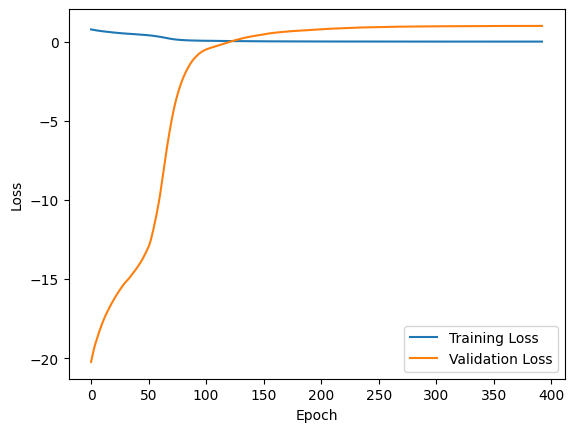

In [33]:
# define the MLP model

np.random.seed(42)

model = MLPRegressor(hidden_layer_sizes=(6,4), activation='relu', solver='adam', alpha=0.00001, max_iter=1000, batch_size='auto', verbose=False, early_stopping=True)

# train the model
history = model.fit(X_train, y_train)

# Plot the training and validation loss curves
plt.plot(history.loss_curve_, label='Training Loss')
plt.plot(model.validation_scores_, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# # plot the training and validation loss curves
# plt.plot(model.loss_curve_, label='Training Loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()


In [34]:
import itertools
# make predictions on the test set
y_pred = model.predict(test_scaled[:, 1:])
y_pred = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1,1), test_scaled[:, 1:]), axis=1))[:, 0]
y_true = test['PPI'].values

# evaluate the model
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# print the metrics
print('number of iterations the solver: ', model.n_iter_)
print('Num of o/p: ', model.n_outputs_)
print('MAE:', mae)
print('MSE:', mse)
print('R2 Score:', r2)

number of iterations the solver:  393
Num of o/p:  1
MAE: 0.009610984150372759
MSE: 0.0001447763448459579
R2 Score: 0.7629239888482963


In [35]:
# print('Actual vs Predicted:')
# print(np.column_stack((y_true, y_pred)))

In [36]:
len(y_true)

104

In [37]:
scaler_y = MinMaxScaler()
train_scaled_y = scaler_y.fit_transform(train.iloc[:, :1])
test_scaled_y = scaler_y.transform(test.iloc[:, :1])
train_y_pred = model.predict(X_train)
train_mape = np.mean(np.abs((scaler_y.inverse_transform(train_y_pred.reshape(-1, 1)) - scaler_y.inverse_transform(y_train.reshape(-1, 1))) / scaler_y.inverse_transform(y_train.reshape(-1, 1))) * 100)
print("Train MAPE: {:.8f}%".format(train_mape))
# train_mape = np.mean(np.abs((X_train - y_train) / np.maximum(X_train, 1e-8))) * 100
# print("Train MAPE: {:.8f}%".format(train_mape))


test_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.28697746%
Test MAPE: 0.23868025%


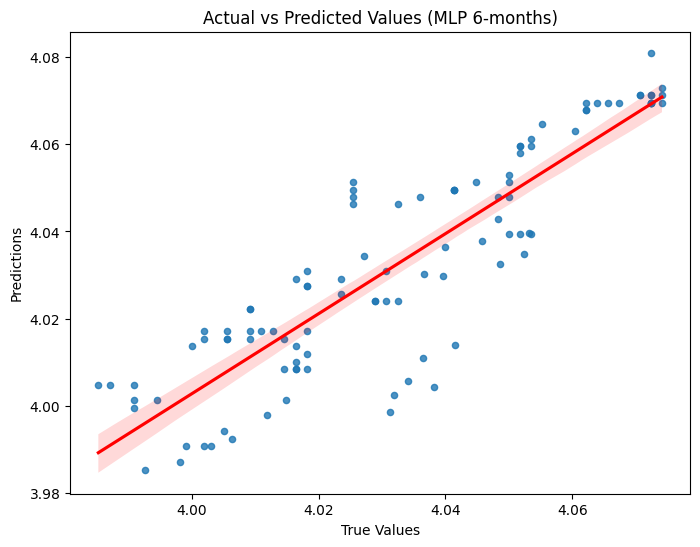

In [38]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot actual vs predicted values
sns.regplot(x=y_true, y=y_pred, scatter_kws={"s": 20}, line_kws={"color": "red"})
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Actual vs Predicted Values (MLP 6-months)")
plt.show()

In [39]:
# n_months = 6

# # Create an array of lagged PPI values for the next n_months
# X = cdf_6M['PPI_Lagged'].tail(n_months).values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
# scaler.fit(X)
# # Scale the input features
# X_scaled = scaler.transform(X)

# # Create an empty array to hold the forecasted PPI values
# forecast = []
# last_observation_scaled = X_scaled[0]
# for i in range(n_months):
#     # Make a prediction based on the last observation

#     y_pred = model.predict([last_observation_scaled])
#     # Inverse transform the prediction
#     y_pred_inv = scaler.inverse_transform([[y_pred, 0]])[0][0]
#     # Append the prediction to the forecast array
#     forecast.append(y_pred_inv)
#     # Update the last observation
#     last_observation_scaled = np.concatenate([y_pred, X_scaled[i][1:]])

# # Create a dataframe to hold the forecasted PPI values
# forecast_df = pd.DataFrame(data=forecast, columns=['PPI'])

# # Create an index for the forecasted PPI values
# forecast_index = pd.date_range(start=cdf_6M.index[-1], periods=6, freq='MS')
# forecast_df.set_index(forecast_index, inplace=True)

# # Plot the predicted PPI values
# plt.plot(range(len(cdf_6M)), cdf_6M['PPI'], label='Historical PPI')
# plt.plot(range(len(cdf_6M), len(cdf_6M)+n_months), forecast_df, label='Forecasted PPI')
# plt.xlabel('Time (months)')
# plt.ylabel('PPI')
# plt.legend()
# plt.show()

# # print the forecasted PPI values
# print(forecast_df.values)

**FORECASTING 12 MONTHS**

In [40]:
df = pd.read_excel("/content/drive/MyDrive/MBA/DataTables_Semis-Forecasting/DataTable_Semis-Forecasting-12M.xlsx")

In [41]:
df.tail(5)

,Date,PPI,PPI_Lagged,GPR,Export_Semis,Import_Semis,Employees_Semis,Export_NoSemis,Import_NoSemis,RIW_Semis,Export_CapitalGoods,IP_NoEnergy
333,2022-09-01,4.039924,4.005058,4.402250,4.117410,4.051785,5.919700,3.808882,4.763882,0.409258,4.943070,4.586990
334,2022-10-01,4.048527,4.006369,4.393845,4.110874,4.055257,5.922382,3.811097,4.766438,0.391772,4.948050,4.596759
335,2022-11-01,4.052446,4.011886,4.490195,4.109233,4.058717,5.923453,3.817712,4.768139,0.382333,4.950177,4.601174
336,2022-12-01,4.053141,4.014941,4.686981,4.105944,4.062166,5.924523,3.824284,4.772378,0.375487,4.953006,4.601456
337,2023-01-01,4.045749,4.031334,4.949697,4.109233,4.072440,5.929855,3.837299,4.782479,0.351150,4.962145,4.599506


In [42]:
df.columns

Index(['Date', 'PPI', 'PPI_Lagged', 'GPR', 'Export_Semis', 'Import_Semis',
       'Employees_Semis', 'Export_NoSemis', 'Import_NoSemis', 'RIW_Semis',
       'Export_CapitalGoods', 'IP_NoEnergy'],
      dtype='object')

In [43]:
cdf_12M = df[['PPI', 'PPI_Lagged','Employees_Semis','Export_NoSemis', 'Import_NoSemis']]

In [44]:
# Split data into train and test sets based on time-series index
train_size = int(len(cdf_12M) * 0.8)
train, test = cdf_12M.iloc[:train_size], cdf_12M.iloc[train_size:]


# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Prepare the data for MLP regression
X_train = train_scaled[:, 1:]
y_train = train_scaled[0:, 0]

# Fit the scaler on the training set only
scaler.fit(train)

# Use the same scaler to transform the testing set
test_with_feature_names = pd.DataFrame(test_scaled, columns=test.columns)
X_test = scaler.transform(test_with_feature_names[:])[:]
y_test = test_scaled[0:, 0]

In [45]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

270
68
270
68


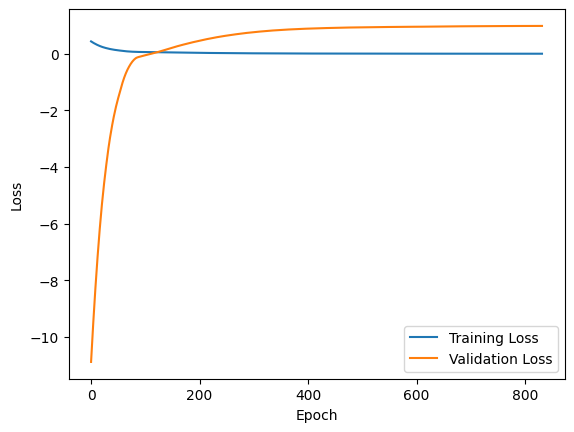

In [46]:
# define the MLP model

np.random.seed(42)

model = MLPRegressor(hidden_layer_sizes=(6,4), activation='relu', solver='adam', alpha=0.1, max_iter=1000, batch_size='auto', verbose=False, early_stopping=True)

# train the model
history = model.fit(X_train, y_train)

# Plot the training and validation loss curves
plt.plot(history.loss_curve_, label='Training Loss')
plt.plot(model.validation_scores_, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# # plot the training and validation loss curves
# plt.plot(model.loss_curve_, label='Training Loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()


In [47]:
import itertools
# make predictions on the test set
y_pred = model.predict(test_scaled[:, 1:])
y_pred = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1,1), test_scaled[:, 1:]), axis=1))[:, 0]
y_true = test['PPI'].values

# evaluate the model
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# print the metrics
print('number of iterations the solver: ', model.n_iter_)
print('Num of o/p: ', model.n_outputs_)
print('MAE:', mae)
print('MSE:', mse)
print('R2 Score:', r2)

number of iterations the solver:  832
Num of o/p:  1
MAE: 0.011139757599153852
MSE: 0.00027761204228919563
R2 Score: -0.00510116277827799


In [48]:
# print('Actual vs Predicted:')
# print(np.column_stack((y_true, y_pred)))

In [49]:
len(y_true)

68

In [50]:
scaler_y = MinMaxScaler()
train_scaled_y = scaler_y.fit_transform(train.iloc[:, :1])
test_scaled_y = scaler_y.transform(test.iloc[:, :1])
train_y_pred = model.predict(X_train)
train_mape = np.mean(np.abs((scaler_y.inverse_transform(train_y_pred.reshape(-1, 1)) - scaler_y.inverse_transform(y_train.reshape(-1, 1))) / scaler_y.inverse_transform(y_train.reshape(-1, 1))) * 100)
print("Train MAPE: {:.8f}%".format(train_mape))
# train_mape = np.mean(np.abs((X_train - y_train) / np.maximum(X_train, 1e-8))) * 100
# print("Train MAPE: {:.8f}%".format(train_mape))


test_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.38721145%
Test MAPE: 0.27644262%


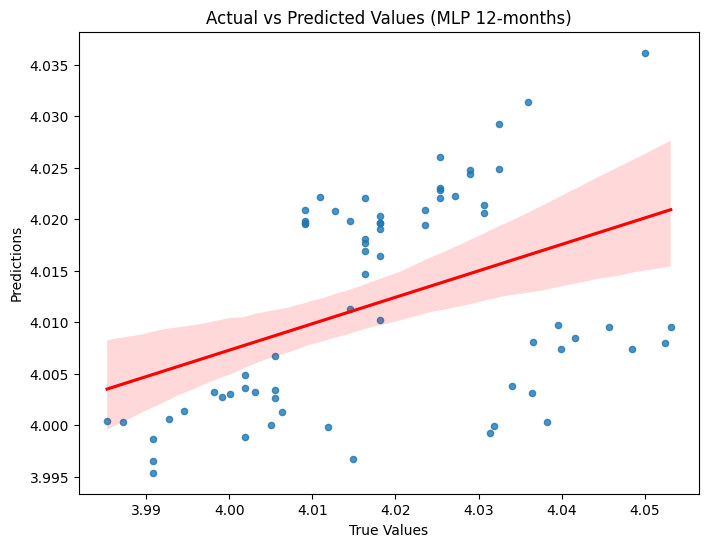

In [51]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot actual vs predicted values
sns.regplot(x=y_true, y=y_pred, scatter_kws={"s": 20}, line_kws={"color": "red"})
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Actual vs Predicted Values (MLP 12-months)")
plt.show()

In [52]:
# n_months = 12

# # Create an array of lagged PPI values for the next n_months
# X = cdf_12M['PPI_Lagged'].tail(n_months).values.reshape(-1, 1)
# scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
# scaler.fit(X)
# # Scale the input features
# X_scaled = scaler.transform(X)

# # Create an empty array to hold the forecasted PPI values
# forecast = []
# last_observation_scaled = X_scaled[0]
# for i in range(n_months):
#     # Make a prediction based on the last observation

#     y_pred = model.predict([last_observation_scaled])
#     # Inverse transform the prediction
#     y_pred_inv = scaler.inverse_transform([[y_pred, 0]])[0][0]
#     # Append the prediction to the forecast array
#     forecast.append(y_pred_inv)
#     # Update the last observation
#     last_observation_scaled = np.concatenate([y_pred, X_scaled[i][1:]])


# # Create a dataframe to hold the forecasted PPI values
# forecast_df = pd.DataFrame(data=forecast, columns=['PPI'])

# # Create an index for the forecasted PPI values
# forecast_index = pd.date_range(start=cdf_12M.index[-1], periods=12, freq='MS')
# forecast_df.set_index(forecast_index, inplace=True)

# # Plot the predicted PPI values
# plt.plot(range(len(cdf_12M)), cdf_12M['PPI'], label='Historical PPI')
# plt.plot(range(len(cdf_12M), len(cdf_12M)+n_months), forecast_df, label='Forecasted PPI')
# plt.xlabel('Time (months)')
# plt.ylabel('PPI')
# plt.legend()
# plt.show()

# # print the forecasted PPI values
# print(forecast_df.values)

**FORECASTING 24 MONTHS**

In [53]:
df = pd.read_excel("/content/drive/MyDrive/MBA/DataTables_Semis-Forecasting/DataTable_Semis-Forecasting-24M.xlsx")

In [54]:
df.tail(5)

,Date,PPI,PPI_Lagged,GPR,Export_Semis,Import_Semis,Employees_Semis,Export_NoSemis,Import_NoSemis,RIW_Semis,Export_CapitalGoods,IP_NoEnergy
321,2022-09-01,4.039924,4.001864,4.386733,4.112512,4.025352,5.900993,3.772761,4.746670,0.501502,4.916325,4.541618
322,2022-10-01,4.048527,3.985273,4.331827,4.112512,4.019980,5.901266,3.761200,4.748404,0.507841,4.916325,4.554317
323,2022-11-01,4.052446,3.987130,4.249459,4.112512,4.019980,5.898252,3.754199,4.749271,0.498044,4.914858,4.558176
324,2022-12-01,4.053141,3.990834,4.159934,4.112512,4.023564,5.900171,3.747148,4.751001,0.475551,4.916325,4.561883
325,2023-01-01,4.045749,3.990834,4.362087,4.112512,4.028917,5.902360,3.756538,4.753590,0.461089,4.920711,4.579043


In [55]:
df.columns

Index(['Date', 'PPI', 'PPI_Lagged', 'GPR', 'Export_Semis', 'Import_Semis',
       'Employees_Semis', 'Export_NoSemis', 'Import_NoSemis', 'RIW_Semis',
       'Export_CapitalGoods', 'IP_NoEnergy'],
      dtype='object')

In [56]:
cdf_24M = df[['PPI',  'PPI_Lagged',  'Export_Semis', 'Import_Semis',
       'Employees_Semis']]

In [57]:
# Split data into train and test sets based on time-series index
train_size = int(len(cdf_24M) * 0.7)
train, test = cdf_24M.iloc[:train_size], cdf_24M.iloc[train_size:]



# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)


# Prepare the data for MLP regression
X_train = train_scaled[:, 1:]
y_train = train_scaled[0:, 0]

# Fit the scaler on the training set only
scaler.fit(train)

# Use the same scaler to transform the testing set
test_with_feature_names = pd.DataFrame(test_scaled, columns=test.columns)
X_test = scaler.transform(test_with_feature_names)
y_test = test_scaled[0:, 0]

In [58]:
print(len(X_train))
print(len(X_test))
print(len(y_train))
print(len(y_test))

228
98
228
98


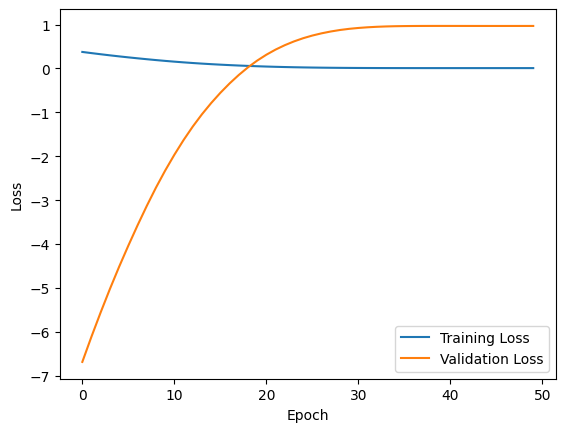

In [59]:
# define the MLP model

np.random.seed(42)

model = MLPRegressor(hidden_layer_sizes=(8,4), activation='tanh', solver='adam', alpha=0.1, max_iter=2000, batch_size='auto', verbose=False, early_stopping=True)

# train the model
history = model.fit(X_train, y_train)

# Plot the training and validation loss curves
plt.plot(history.loss_curve_, label='Training Loss')
plt.plot(model.validation_scores_, label='Validation Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

# # plot the training and validation loss curves
# plt.plot(model.loss_curve_, label='Training Loss')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.show()


In [60]:
import itertools
# make predictions on the test set

y_pred = model.predict(test_scaled[:, 1:])
y_pred = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1,1), test_scaled[:, 1:]), axis=1))[:, 0]
y_true = test['PPI'].values

# evaluate the model
r2 = r2_score(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
mse = mean_squared_error(y_true, y_pred)

# print the metrics
print('number of iterations the solver: ', model.n_iter_)
print('Num of o/p: ', model.n_outputs_)
print('MAE:', mae)
print('MSE:', mse)
print('R2 Score:', r2)

number of iterations the solver:  50
Num of o/p:  1
MAE: 0.013079527101235642
MSE: 0.00037054705224917795
R2 Score: 0.3150956807299051


In [61]:
# print('Actual vs Predicted:')
# print(np.column_stack((y_true, y_pred)))

In [62]:
len(y_true)

98

In [63]:
scaler_y = MinMaxScaler()
train_scaled_y = scaler_y.fit_transform(train.iloc[:, :1])
test_scaled_y = scaler_y.transform(test.iloc[:, :1])
train_y_pred = model.predict(X_train)
train_mape = np.mean(np.abs((scaler_y.inverse_transform(train_y_pred.reshape(-1, 1)) - scaler_y.inverse_transform(y_train.reshape(-1, 1))) / scaler_y.inverse_transform(y_train.reshape(-1, 1))) * 100)
print("Train MAPE: {:.8f}%".format(train_mape))
# train_mape = np.mean(np.abs((X_train - y_train) / np.maximum(X_train, 1e-8))) * 100
# print("Train MAPE: {:.8f}%".format(train_mape))


test_mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print("Test MAPE: {:.8f}%".format(test_mape))

Train MAPE: 0.50062258%
Test MAPE: 0.32518648%


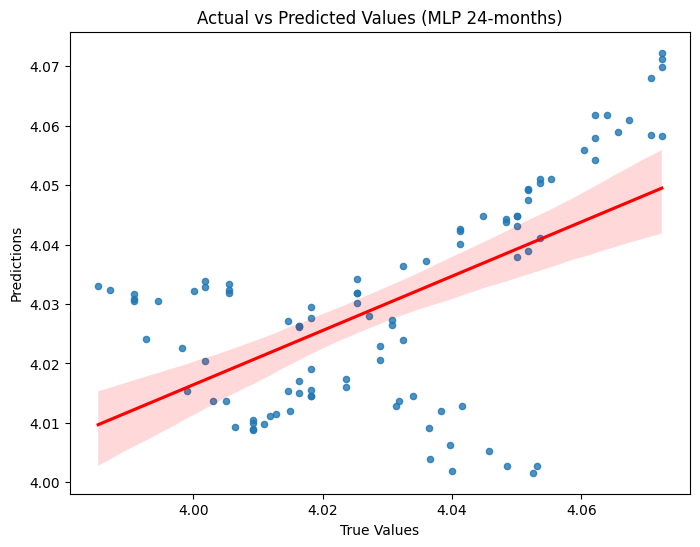

In [64]:
fig, ax = plt.subplots(figsize=(8, 6))

# plot actual vs predicted values
sns.regplot(x=y_true, y=y_pred, scatter_kws={"s": 20}, line_kws={"color": "red"})
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.title("Actual vs Predicted Values (MLP 24-months)")
plt.show()

In [65]:
# n_months = 24

# # Create an array of lagged PPI values for the next n_months
# X = cdf_24M[['PPI_Lagged','Employees_Semis']].tail(n_months)
# scaler = MinMaxScaler(feature_range=(0, 1), copy=False)
# scaler.fit(X)
# # Scale the input features
# X_scaled = scaler.transform(X)

# # Create an empty array to hold the forecasted PPI values
# forecast = []
# last_observation_scaled = X_scaled[0]
# for i in range(n_months):
#     # Make a prediction based on the last observation
#     y_pred = model.predict([last_observation_scaled])
#     # Inverse transform the prediction
#     y_pred_inv = scaler.inverse_transform([[y_pred, 0]])[0][0]
#     # Append the prediction to the forecast array
#     forecast.append(y_pred_inv)
#     # Update the last observation
#     last_observation_scaled = np.concatenate([y_pred, X_scaled[i][1:]])


# # Create a dataframe to hold the forecasted PPI values
# forecast_df = pd.DataFrame(data=forecast, columns=['PPI'])

# # Create an index for the forecasted PPI values
# forecast_index = pd.date_range(start=cdf_24M.index[-1], periods=24, freq='MS')
# forecast_df.set_index(forecast_index, inplace=True)

# # Plot the predicted PPI values
# plt.plot(range(len(cdf_24M)), cdf_24M['PPI'], label='Historical PPI')
# plt.plot(range(len(cdf_24M), len(cdf_24M)+n_months), forecast_df, label='Forecasted PPI')
# plt.xlabel('Time (months)')
# plt.ylabel('PPI')
# plt.legend()
# plt.show()

# # print the forecasted PPI values
# print(forecast_df.values)

**TESTING**

In [66]:
# train_size = int(len(cdf_1M) * 0.5)
# train, test = cdf_1M.iloc[:train_size], cdf_1M.iloc[train_size:]
# scaler = MinMaxScaler()
# train_scaled = scaler.fit_transform(train)
# test_scaled = scaler.transform(test)

In [67]:
# train_mse = history.loss_
# test_mse = mean_squared_error(test_scaled[:, 0], model.predict(test_scaled[:, 1:]))

# # plot the training and test MSE curves
# plt.plot(train_mse, label='Training MSE')
# plt.plot(test_mse, label='Test MSE')
# plt.legend()
# plt.xlabel('Epoch')
# plt.ylabel('MSE')
# plt.show()

In [68]:
# import itertools
# make predictions on the test set
# y_pred = model.predict(test_scaled[:, 1:])
# y_pred = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1,1), test_scaled[:, 1:]), axis=1))[:, 0]
# y_true = test['PPI'].values

# # evaluate the model
# r2 = r2_score(y_true, y_pred)
# mae = mean_absolute_error(y_true, y_pred)
# mse = mean_squared_error(y_true, y_pred)

# # print the metrics
# print('number of iterations the solver: ', model.n_iter_)
# print('num of layers: ', model.n_layers_)
# print('Num of o/p: ', model.n_outputs_)
# print('R2 Score:', r2)
# print('MAE:', mae)
# print('MSE:', mse)

In [69]:
# make predictions on the test set
# y_pred = model.predict(test_scaled[:, 1:])
# y_pred = scaler.inverse_transform(np.concatenate((y_pred.reshape(-1,1), test_scaled[:, 1:]), axis=1))[:, 0]
# y_true = test['PPI'].values

In [70]:
# n_months = 1

# # Create an array of lagged PPI values for the next n_months
# X = cdf_1M[['PPI_Lagged']].tail(n_months)
# X_scaled = scaler.transform(X)
# y_pred_scaled = model.predict(X_scaled)
# y_pred = scaler.inverse_transform(np.concatenate((y_pred_scaled.reshape(-1,1), X_scaled[:, 1:]), axis=1))[:, 0]

# forecast_df = pd.DataFrame(data=y_pred.ravel(), columns=['PPI'])

# forecast_index = pd.date_range(start=cdf_1M.index[-1], periods=2, freq='MS')
# forecast_df.set_index(forecast_index, inplace=True)

# # Plot the predicted PPI values
# plt.plot(range(len(cdf_1M)), cdf_1M['PPI'], label='Historical PPI')
# plt.plot(range(len(cdf_1M), len(cdf_1M)+n_months), forecast_df, label='Forecasted PPI')
# plt.xlabel('Time (months)')
# plt.ylabel('PPI')
# plt.legend()
# plt.show()

# print(forecast_df.values)

In [71]:
# n_months = 12
# # make predictions on the test set
# y_pred_test = model.predict(test_scaled[:, 1:])
# y_pred_test = scaler.inverse_transform(np.concatenate((y_pred_test.reshape(-1,1), test_scaled[:, 1:]), axis=1))[:, 0]

# # forecast for the next n_months
# last_observation = test.iloc[-1]['PPI']
# forecast = []
# for i in range(n_months):
#     # scale the last observation and make a prediction
#     last_observation_scaled = scaler.transform([[last_observation, 0]])[0][0]
#     y_pred = model.predict([[last_observation_scaled]])
#     # inverse transform the prediction and append it to the forecast
#     y_pred = scaler.inverse_transform([[y_pred, 0]])[0][0]
#     forecast.append(y_pred)
#     # update the last observation
#     last_observation = y_pred

# # Plot the predicted PPI values
# plt.plot(range(len(cdf_12M)), cdf_12M['PPI'], label='Historical PPI')
# plt.plot(range(len(cdf_12M), len(cdf_12M)+n_months), forecast, label='Forecasted PPI')
# plt.xlabel('Time (months)')
# plt.ylabel('PPI')
# plt.legend()
# plt.show()

# # print the forecast
# print(forecast)